In [68]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
keras.utils.vis_utils.pydot = pyd

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [6]:
def create_series(n_=1000):
    '''
    Create 2 series adding noise and trend
    to 2 Sine waves
    '''
    t = np.linspace(0, 50*np.pi, n_)
    # pattern + trend + noise
    x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
    x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
    return x1, x2

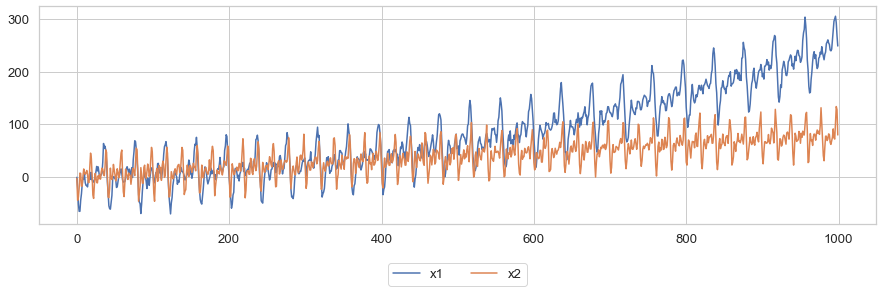

In [9]:
x1, x2 = create_series(n_=1000)

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.grid(b=True)
plt.show()

In [12]:
train_ratio = 0.8
train_len = int(train_ratio * len(x1))
print(train_len)

800


## Detrending

It is not a must to detrend time series. However stationary time series will make model training much easier. There are many ways to detrend time series, such as taking difference of sequence with its lag1. Here for the simplicity, we assume the order of trend is known and we are just going to simply fit separate trend lines to x1 and x2, and then subtract the trend from the corresponding original sequence.
We will create index number of each position in the sequence, for easier detrending and trend recover.

We will create index number of each position in the sequence, for easier detrending and trend recover. Here we will use `np.polyfit` to complete this small task. Note that only the first 800 data points are used to fit the trend lines, this is because we want to avoid data leak.

[ 2.42269661e-04  1.02962658e-02 -2.99873186e+00]
[ 0.08097167 -1.16476853]


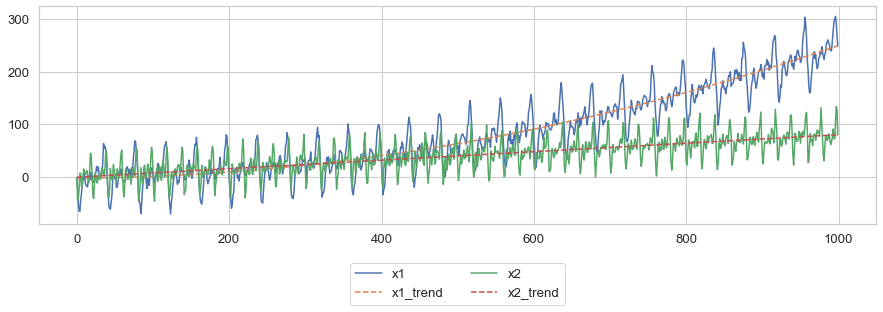

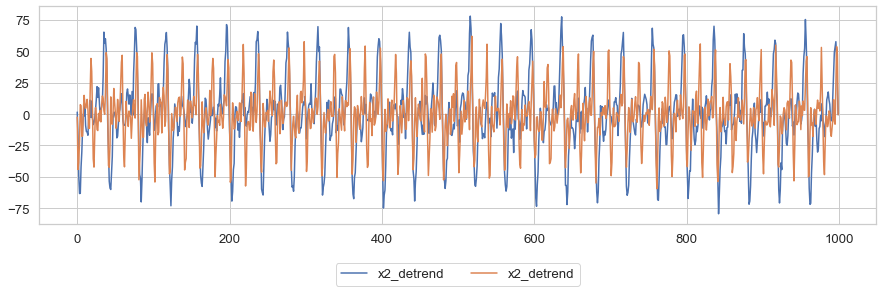

In [21]:
x_index = np.array(range(len(x1)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# The above result looks fine, now we can deduct the trend.
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Combine sequences and Normalize

For easier preprocessing in next several steps, we can combine the sequences and their relevant information together into one array. In the combined array we created x_lbl:
- the first column is the detrended x1
- the second column is the detrended x2
- the third column is the index
- the fourth column is the label (1 for train set and 0 for test set)

In [22]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[ 1.58193512e+00 -2.44191165e+00  0.00000000e+00  1.00000000e+00]
 [-1.81426610e+01 -4.40830546e+01  1.00000000e+00  1.00000000e+00]
 [-4.93314525e+01 -3.84181324e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 4.47384502e+01  5.37664717e+01  9.97000000e+02  0.00000000e+00]
 [ 1.95961977e+01  4.76209502e+01  9.98000000e+02  0.00000000e+00]
 [-4.60034691e-01 -5.05206587e-01  9.99000000e+02  0.00000000e+00]]


In [23]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[78.05640225161014, 62.077329068842225, 1, 1]


Note that the above code only calculates maximum value of column 1 (detrended x1) and column 2 (detrended x2), the denominator of column 3 (index) and column 4 (label) are set to 1. This is because we do not input column 3 and column 4 into neural network, and hence no need to normalise them.

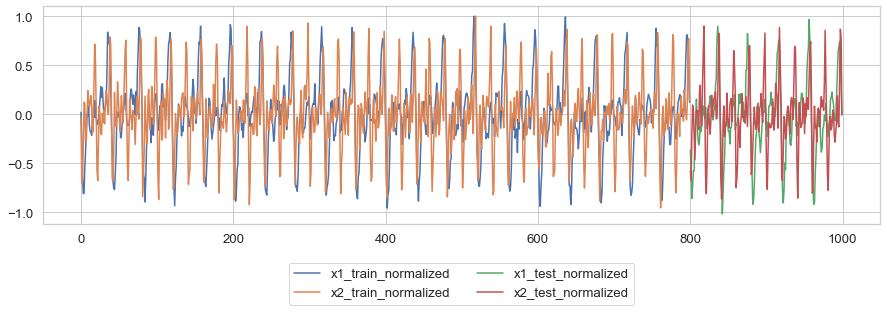

In [25]:
x_normalize = np.divide(x_lbl, x_train_max)

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Truncate
Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays. The function truncate generates 3 arrays:
- input to neural network X_in: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: detrended and normalised x1, detrended and normalised x2, and original assigned data position index. Only the first 2 features will be used for training.
- target in neural network X_out: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in X_in. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.
- label lbl: 1 for train set and 0 for test set.

In [29]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [30]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


## Simple LSTM Seq2Seq
The encoder LSTM cell: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.

The decoder LSTM cell: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

The encoder LSTM<br>
We need to pay attention to 2 import parameters return_sequences and return_state, because they decide what LSTM returns.
- `return_sequences=False`, `return_state=False`: return the last hidden state: state_h
- `return_sequences=True`, `return_state=False`: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- `return_sequences=False`, `return_state=True`: return 3 arrays: state_h, state_h, state_c
- `return_sequences=True`, `return_state=True`: return 3 arrays: stacked hidden states, last state_h, last state_c
For simple Seq2Seq model, we only need last state_h and last state_c.

In [156]:
# Hidden Layers
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

print(input_train)
print(output_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

Tensor("input_21:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_22:0", shape=(None, 20, 2), dtype=float32)
Tensor("lstm_19/strided_slice_3:0", shape=(None, 100), dtype=float32)
Tensor("lstm_19/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_19/while:5", shape=(None, 100), dtype=float32)


In [157]:
# Batch normalisation is added because we want to avoid gradient
# explosion caused by the activation function ELU in the encoder.
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

Next, we make 20 copies of the last hidden state of encoder and use them as input to the decoder. The last cell state and the last hidden state of the encoder are also used as the initial states of decoder.

In [158]:
# Create copies of las hidden state
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(decoder)
print(out)

Tensor("lstm_20/transpose_1:0", shape=(None, 20, 100), dtype=float32)
Tensor("time_distributed_8/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


Then we put everything into the model, and compile it. <br>
Here we simply use MSE as the loss function and MAE as the evaluation metric. Note that we set `clipnorm=1` for Adam optimiser. This is to normalise the gradient, so as to avoid gradient explosion during back propagation

In [159]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  [(None, 100), (None, 41200       input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 100)          400         lstm_19[0][0]                    
__________________________________________________________________________________________________
repeat_vector_8 (RepeatVector)  (None, 20, 100)      0           batch_normalization_13[0][0]     
______________________________________________________________________________________

In [160]:
from IPython.display import HTML
from keras.utils.vis_utils import plot_model, model_to_dot
# this is for making Graphviz work (plot_model needs GraphViz)
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

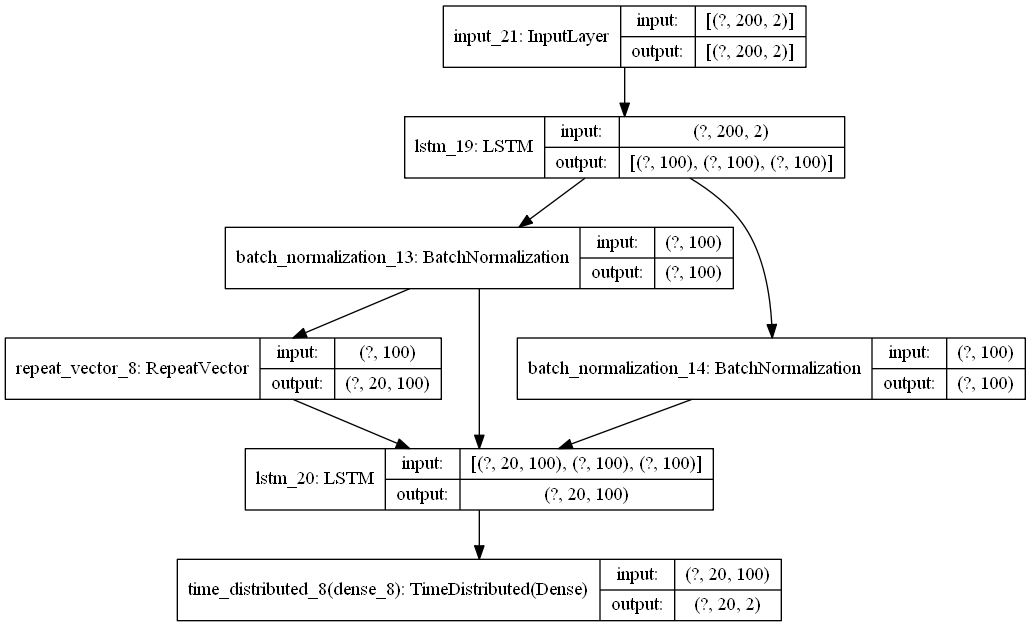

In [161]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96)

In [94]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=2, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/100
5/5 - 3s - loss: 0.0815 - mae: 0.2053 - val_loss: 0.0679 - val_mae: 0.1889
Epoch 2/100
5/5 - 3s - loss: 0.0686 - mae: 0.1948 - val_loss: 0.0525 - val_mae: 0.1666
Epoch 3/100
5/5 - 3s - loss: 0.0574 - mae: 0.1766 - val_loss: 0.0466 - val_mae: 0.1553
Epoch 4/100
5/5 - 3s - loss: 0.0516 - mae: 0.1670 - val_loss: 0.0418 - val_mae: 0.1453
Epoch 5/100
5/5 - 3s - loss: 0.0507 - mae: 0.1654 - val_loss: 0.0396 - val_mae: 0.1452
Epoch 6/100
5/5 - 3s - loss: 0.0455 - mae: 0.1572 - val_loss: 0.0460 - val_mae: 0.1497
Epoch 7/100
5/5 - 3s - loss: 0.0483 - mae: 0.1601 - val_loss: 0.0332 - val_mae: 0.1291
Epoch 8/100
5/5 - 3s - loss: 0.0524 - mae: 0.1665 - val_loss: 0.0391 - val_mae: 0.1413
Epoch 9/100
5/5 - 3s - loss: 0.0455 - mae: 0.1567 - val_loss: 0.0337 - val_mae: 0.1344
Epoch 10/100
5/5 - 3s - loss: 0.0409 - mae: 0.1502 - val_loss: 0.0260 - val_mae: 0.1159
Epoch 11/100
5/5 - 3s - loss: 0.0430 - mae: 0.1516 - val_loss: 0.0423 - val_mae: 0.1460
Epoch 12/100
5/5 - 3s - loss: 0.0458 - ma

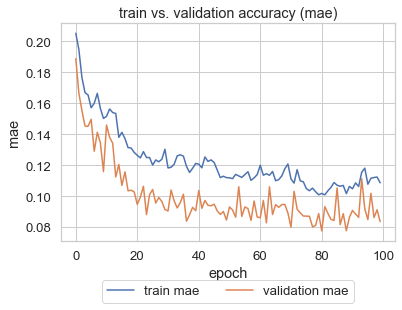

In [95]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Prediction
The model prediction as well as the true values are unnormalised:

In [96]:
# Unnormalize
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]

print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.

In [97]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [98]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


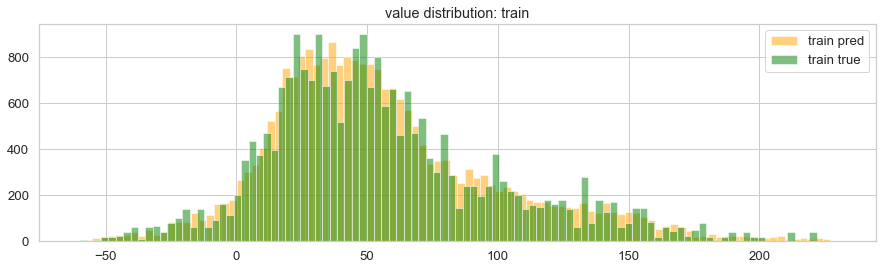

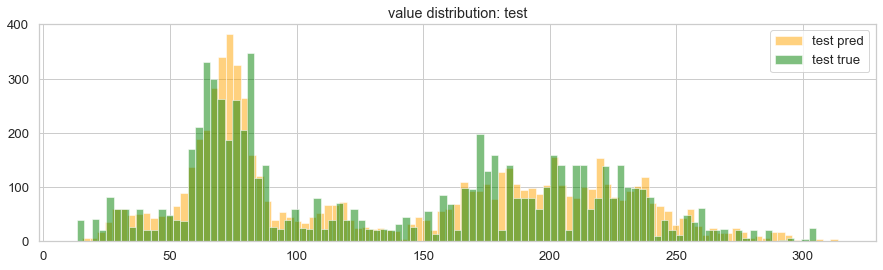

In [99]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

The data distribution of prediction and true values are almost overlapped, so we are good.
We can also plot MAE of all samples in time order, to see if there is clear pattern. The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.|

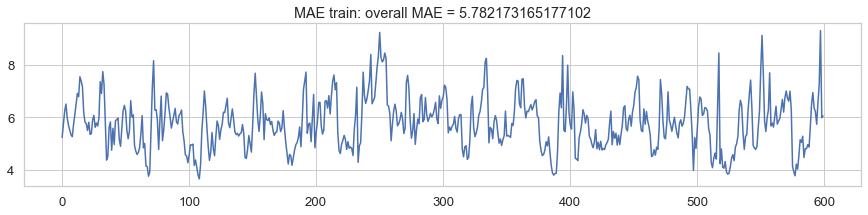

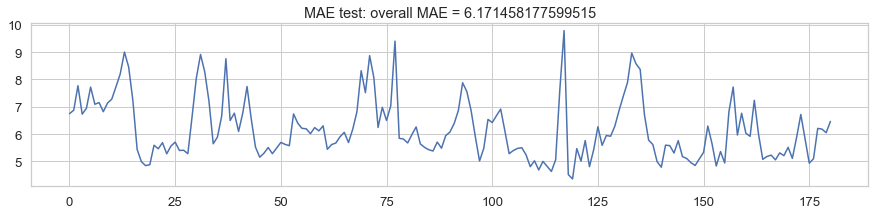

In [101]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.
Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned.

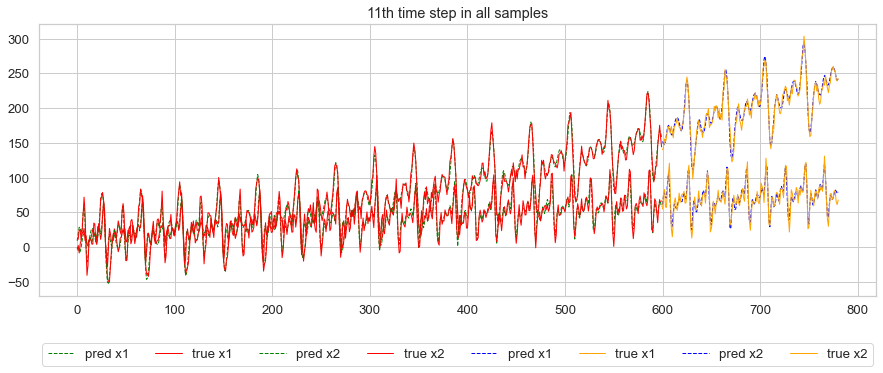

In [102]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

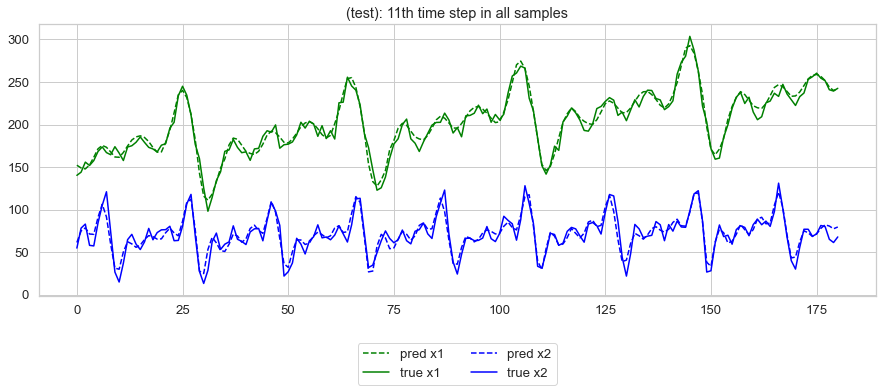

In [103]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Model 2: Seq2Seq LSTM Model with Luong Attention

Next we will build Luong Attention on top of Model 1, and use Dot method to calculate alignment score.

In [131]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)

#encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)
print(decoder_input)

Tensor("lstm_15/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm_15/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_15/while:5", shape=(None, 100), dtype=float32)
Tensor("repeat_vector_6/Tile:0", shape=(None, 20, 100), dtype=float32)


We also need to get the stacked hidden state of de decoder for alignment score calculation.

In [132]:
decoder_stack_h = LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_16/transpose_1:0", shape=(None, 20, 100), dtype=float32)


### Attention Layer
To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [133]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_2/truediv:0", shape=(None, 20, 200), dtype=float32)


Then we can calculate the context vector, and also apply batch normalisation on top of it:

In [134]:
context = dot([attention, encoder_stack_h], axes=[2,1])
#context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("dot_5/MatMul:0", shape=(None, 20, 100), dtype=float32)


Now we concat the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.

In [135]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("concatenate_2/concat:0", shape=(None, 20, 200), dtype=float32)
Tensor("time_distributed_6/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [136]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(None, 200, 100), ( 41200       input_17[0][0]                   
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 20, 100)      0           lstm_15[0][1]                    
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 20, 100)      80400       repeat_vector_6[0][0]            
                                                                 lstm_15[0][1]        

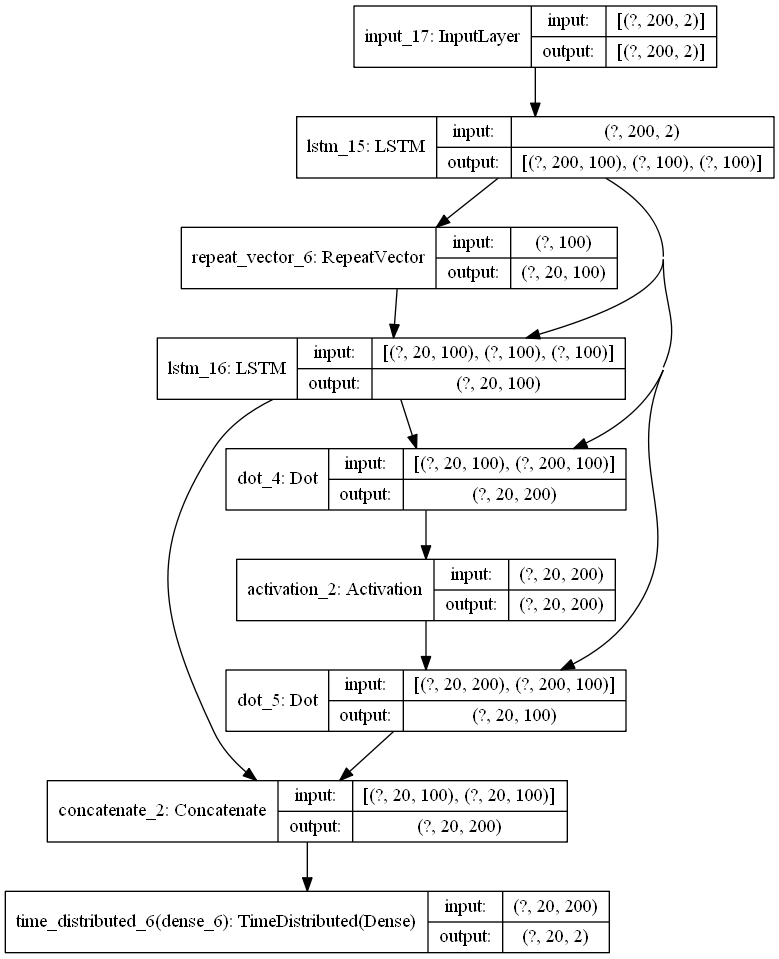

In [137]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96)

In [138]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=2, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

Epoch 1/100
5/5 - 4s - loss: 0.1324 - mae: 0.2665 - val_loss: 0.1248 - val_mae: 0.2477
Epoch 2/100
5/5 - 4s - loss: 0.1251 - mae: 0.2575 - val_loss: 0.1182 - val_mae: 0.2411
Epoch 3/100
5/5 - 4s - loss: 0.1178 - mae: 0.2506 - val_loss: 0.1091 - val_mae: 0.2351
Epoch 4/100
5/5 - 4s - loss: 0.1092 - mae: 0.2446 - val_loss: 0.0962 - val_mae: 0.2247
Epoch 5/100
5/5 - 4s - loss: 0.0996 - mae: 0.2341 - val_loss: 0.0870 - val_mae: 0.2112
Epoch 6/100
5/5 - 4s - loss: 0.0948 - mae: 0.2267 - val_loss: 0.0777 - val_mae: 0.2011
Epoch 7/100
5/5 - 4s - loss: 0.0870 - mae: 0.2190 - val_loss: 0.0715 - val_mae: 0.1952
Epoch 8/100
5/5 - 4s - loss: 0.0752 - mae: 0.2064 - val_loss: 0.0633 - val_mae: 0.1848
Epoch 9/100
5/5 - 5s - loss: 0.0677 - mae: 0.1959 - val_loss: 0.0554 - val_mae: 0.1728
Epoch 10/100
5/5 - 4s - loss: 0.0648 - mae: 0.1910 - val_loss: 0.0556 - val_mae: 0.1753
Epoch 11/100
5/5 - 4s - loss: 0.0626 - mae: 0.1885 - val_loss: 0.0509 - val_mae: 0.1675
Epoch 12/100
5/5 - 4s - loss: 0.0590 - ma

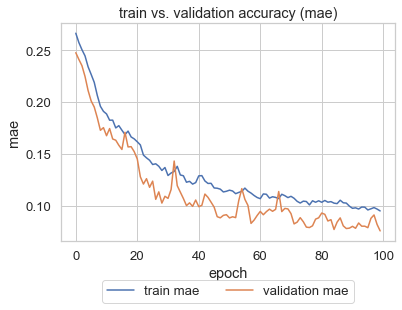

In [139]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [140]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [141]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [142]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [143]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
233.9201450938021
maximum: train_true
221.92405303124616
maximum: test_pred
310.5471547554787
maximum: test_true
305.2902047187258


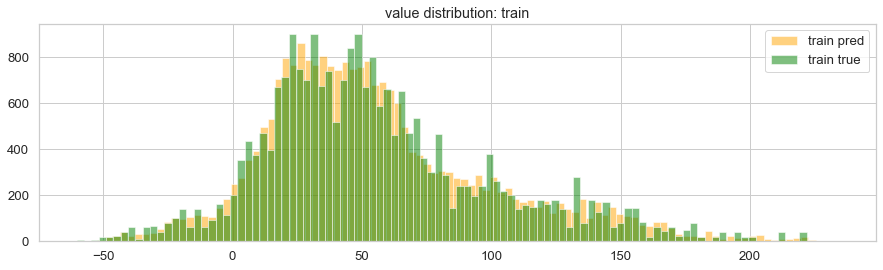

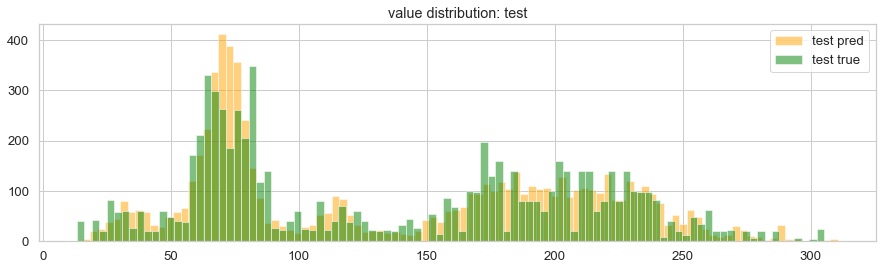

In [144]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

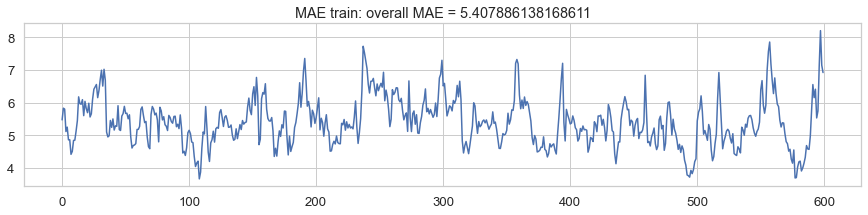

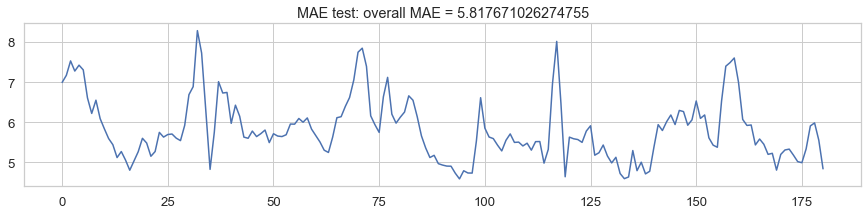

In [145]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

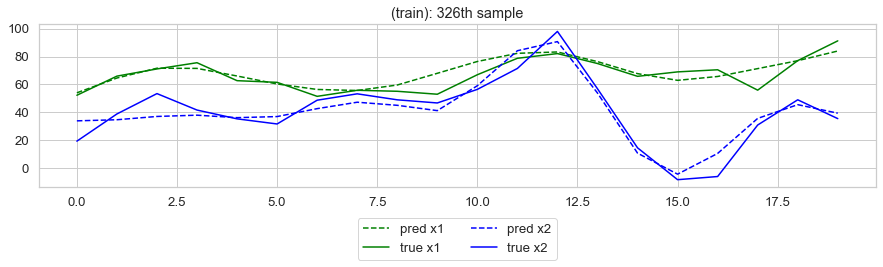

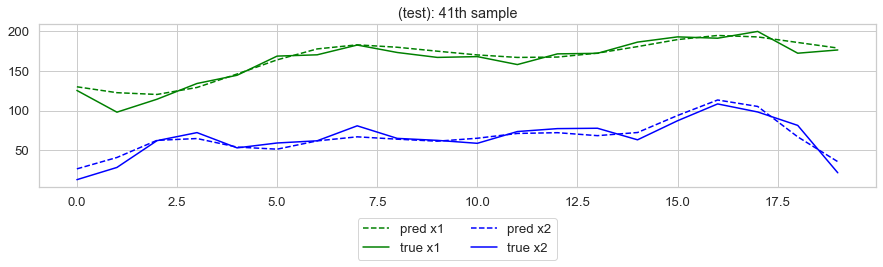

In [149]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))
    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

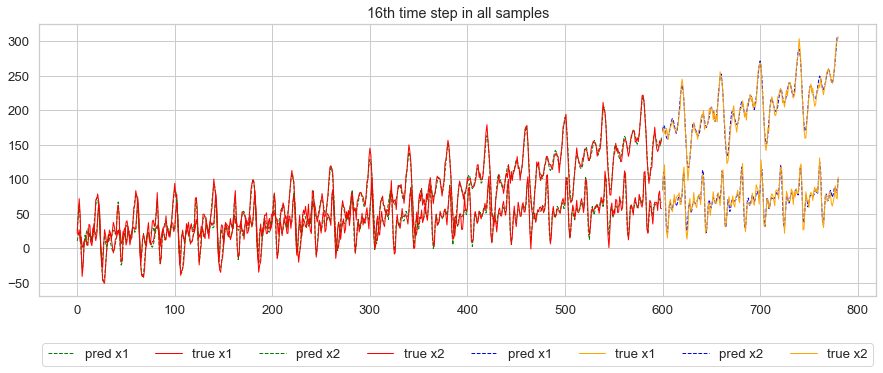

In [147]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

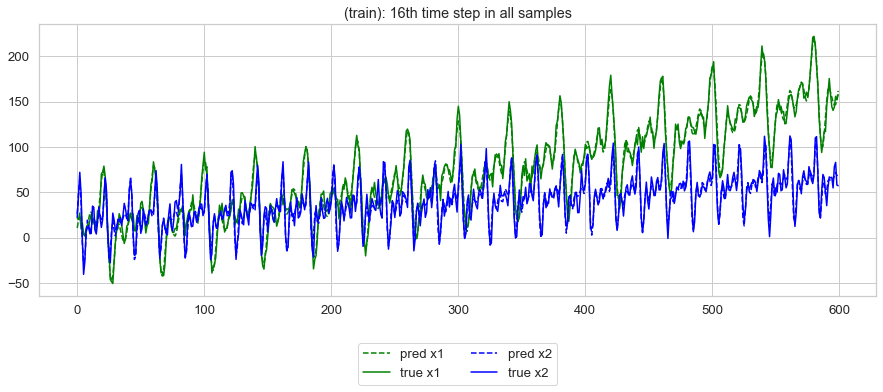

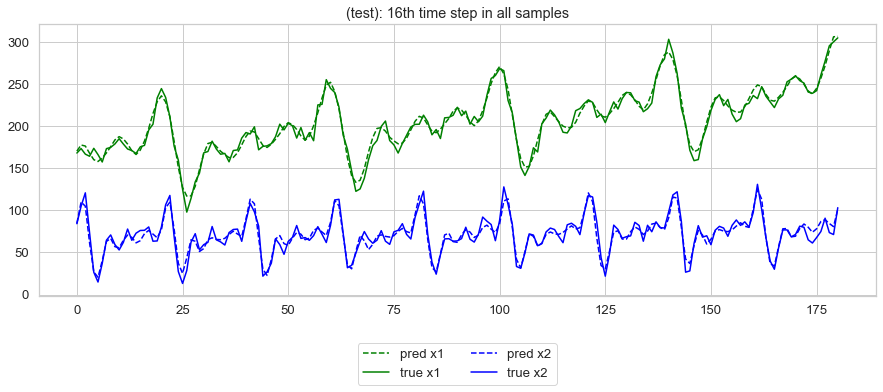

In [148]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()